# Assignment 4

*Due on November 11th, 2020*

## Group Members

* Shai Slav (Collaborated on problem 1, fixed plots on problem 2,implemented RK4,)
* Mark Forese (Formatted questions, collaborated on problem 1, started problem 2,)


In [1]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

### Problem 1: What on erf?!

By this time in the semester, you’ve seen a Gaussian a few times. This one should look no different:

$$f(t;\sigma) = \frac{1}{\sqrt{2 \, \pi \sigma^2}}\exp{\left(-\frac{t^2}{2\,\sigma^2}\right)} \;\;\;\; (1)$$

And you might even remember integrating that Gaussian, at least over the entire real line:

$$\int_{-\infty}^{\infty} dt f(t;\sigma) = 2 \int_0^{\infty} f(t;\sigma) = 1 \;\;\;\; (2)$$

But have you ever tried to integrate a Gaussian over a *finite* portion of the real line? No?

Well actually, you have (if only indirectly)! Remember Assignment 2, Problem 3? If you do, then this beast should look familiar:

$$\int_{-x}^{x} dt f(t;\sigma)= 2 \int_0^{x} dt f(t;\sigma) \equiv \text{erf}\left(\frac{x}{\sqrt{2\sigma^2}}\right) \;\;\;\; (3)$$

Let’s have some fun with it.

#### Part A (0.25 points)

Python knows about erf (the “error function”):
```
from scipy import special
print("erf(1) =",special.erf(1))
```

Matlab knows about erf too: ```erf(x)``` Set $\sigma = 1/\sqrt{2}$ in (3) and make a plot of erf(x) for
x $\in [0, 2\sqrt{2}]$. 

(Handy fact: for a Gaussian, the values less than n standard deviations away from the mean account for a fraction erf$\left(\frac{n}{\sqrt{2}}\right)$ of the set.) 

erf(1)  0.8427007929497148


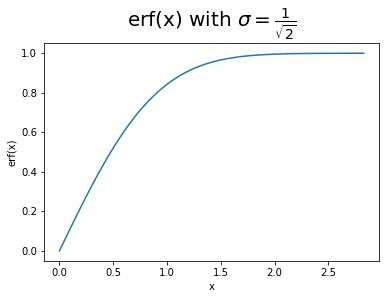

In [2]:
from scipy import special
print('erf(1) ',special.erf(1))

x = np.linspace(0,2*np.sqrt(2),100)
erfs = special.erf(x)

plt.plot(x,erfs)
plt.xlabel('x')
plt.ylabel('erf(x)')

plt.title(r'erf(x) with $\sigma = \frac{1}{\sqrt{2}}$',fontsize = 20)
plt.show()

#### Part B (2 points)

Suppose you weren’t so fortunate as to have erf pre-programmed into python and matlab. You’d have to calculate (3) numerically. And that’s just what you’ll do. Use (1) Monte-Carlo integration with uniform sampling to calculate erf($\sqrt{2}$). Plot the error vs. the number of random samples N $\in [1, 10^6]$ used in the integration and show that it converges as $\sim 1 / \sqrt{N}$. A reminder of the algorith: for N samples $x_i \in [a,b]$,

$$\mathcal{I} = \int_a^b dx f(x) \approx \mathcal{I} \equiv (b - a)\langle f \rangle \pm (b - a) \sqrt{\frac{\langle f^2 \rangle - \langle f \rangle^2}{N}}\:\;\;\;\;\text{ (4) }$$

where:

$$\langle f \rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} f(x_i)$$

and,

$$\langle f^2 \rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} f^2(x_i)$$

Note that the $\pm$ error term here is only an estimate - there is no guarantee that the error is distributed as a Gaussian. 

Indeed, **plot $| \mathcal{I} - \mathcal{I}(N) | \, / \, \mathcal{I}$ (i.e., the percent difference between the “true” answer from ```special.erf(x)``` and your numerical answer) versus N** and you’ll see that the error term in (4) gets accurate only once $N \gg 1$. (You can only do this comparison if you know the exact answer; but if you did, then you wouldn’t be doing numerical integration in the first place! That means that the error estimate in (4) is usually all you have on which to rely.)

In [3]:
def f(t, sigma = 1/np.sqrt(2)):
    '''A gaussian function with standard deviation sigma
    
    Inputs:
    t: ndarray. simply the independent variable in the gaussian
    
    sigma: float, optional. Standard deviation of the Gaussian. Default is 1 / sqrt(2).
    
    Return:
    f: float. Gaussian with standard deviation sigma evaluated at t'''
    
    return 2 / (np.sqrt(2*np.pi*sigma**2)) *np.exp(-t**2/(2*sigma**2))


def monte_carlo(a,b,num_samples):
    '''generates an estimate for erf(x) using monte carlo integration. Can be generalized to other functions.
    
    Inputs:
    
    a: float. Lower limit of the integration. If a == 0, we assume that the function is even and being integrated 
    from -b to b
    
    b: float. Upper limit of the integration
    
    num_samples: int. Number of independent samples to draw from the interval (a,b)
    
    Return: 
    I: float. Estimate of the integral.'''
    
    rand_xs = np.random.uniform(low = a,high = b,size = num_samples)
    evals = np.zeros(num_samples)
    
    evals = f(rand_xs)

        
    f_av = sum(evals)/num_samples
    f_squared_av = sum(evals**2)/num_samples
    
    I = (b-a)*f_av
    
    
    error = np.sqrt((f_squared_av - f_av**2)/num_samples) #check this factor of 2
    
    return (I,error)

In [4]:
Ns = np.logspace(1,6,base = 10,num=250)
#print(Ns)
estimates = np.zeros(Ns.size)
errors = np.zeros(Ns.size)
a = 0
b = np.sqrt(2)

for i in range(len(Ns)):
    N = int(Ns[i])
    #print(N)
    estimates[i],errors[i] = monte_carlo(a,b,N)

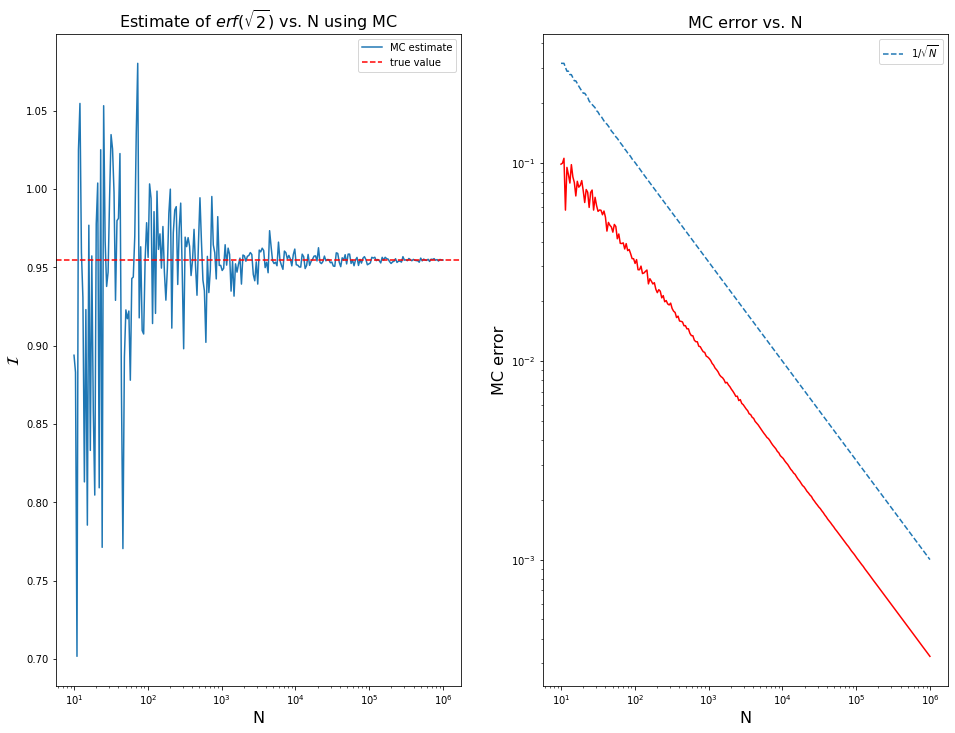

In [5]:
plt.figure(figsize = (16,12))

ax_1 = plt.subplot(121)

plt.plot(Ns,estimates,label = 'MC estimate')
plt.axhline(special.erf(np.sqrt(2)),linestyle ='--',c = 'r',label = 'true value')

ax_1.set_title(r'Estimate of $erf(\sqrt{2})$ vs. N using MC',fontsize = 16)
ax_1.set_xlabel('N',fontsize = 16)
ax_1.set_ylabel(r'$\mathcal{I}$',fontsize = 16)

ax_1.set_xscale('log',basex = 10)
ax_1.legend()

ax_2 = plt.subplot(122)

decay_rate = [np.sqrt(1 / int(N)) for N in Ns]

plt.plot(Ns,errors,c = 'r')
plt.plot(Ns,decay_rate,linestyle = '--',label =r'1/$\sqrt{N}$')
ax_2.set_xscale('log',basex = 10)
ax_2.set_yscale('log',basey = 10)

ax_2.set_xlabel('N',fontsize = 16)
ax_2.set_ylabel('MC error',fontsize = 16)
ax_2.set_title('MC error vs. N',fontsize = 16)

#ax_2.set_ylim(1e-4,0.1)
ax_2.legend()
plt.show()

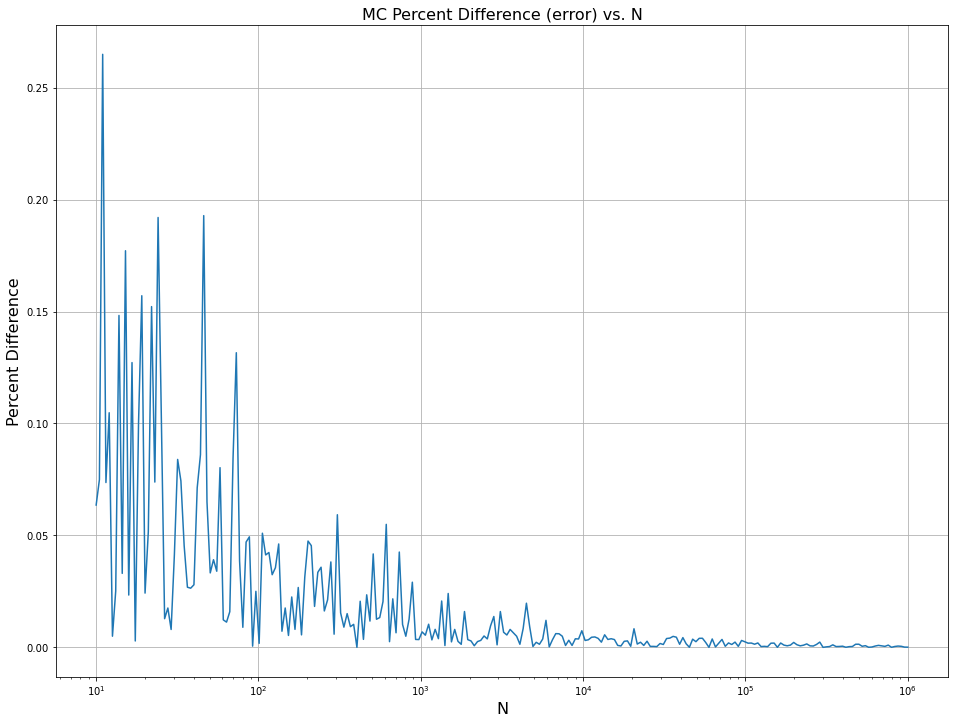

In [6]:
pct_diff = abs(special.erf(np.sqrt(2)) - estimates) / special.erf(np.sqrt(2))
#print(pct_diff)

plt.figure(figsize = (16,12))
ax = plt.subplot(111)

ax.plot(Ns,pct_diff)
ax.set_xscale('log',basex=10)
#ax.set_yscale('log',basey=10)

ax.set_title('MC Percent Difference (error) vs. N',fontsize = 16)
ax.set_xlabel('N',fontsize = 16)
ax.set_ylabel('Percent Difference',fontsize = 16)

plt.grid(True)
plt.show()       

As can be seen in the plot of MC error vs. N, the error converges just like $1/\sqrt{N}$.

#### Part C (1.5 points)

Doing uniform sampling of a peaked distribution (such as a Gaussian) is incredibly inefficient. Most of the time, you’re taking samples from pieces of the integrand that hardly contribute to the integral. There must be a better way, and there is: “importance sampling”. I mentioned this algorithm in class, but review it here to be self-contained.

The idea is to write:

$$\mathcal{I} = \int_a^b dx g(x) \frac{f(x)}{g(x)} = \int_a^b dG(x) \frac{f(x)}{g(x)} = \int_{G(a)}^{G(b)} dr \frac{f(G^{-1}(r))}{g(G^{-1}(r))}$$

with:

$$G(x) \equiv \int_a^x dx' g(x')$$

for some wisely chosen function g(x) > 0, and then sample not f uniformly but rather f/g nonuniformly, the function g dictating how do to the nonuniform sampling. (Essentially, you’re asking what is the expectation value of f/g given the probability distribution g.) How does one choose g? Well, you’d want to sample the integrand with a higher density of points in the region(s) where the integrand is large. One can prove that setting g = $|f|\, / \int dx|f|$ minimixes the variance (and thus the error for a given N). The issue is that drawing random samples from a |f|-distributed probability distribution function is basically what we were trying to do in the first place.

So, instead try the following. We just want something that is close to being proportional to |f| and can be analytically integrated. Set $g(x) \propto e^{-\sqrt{2}x}$, which decreases by a factor of $e^2$ from x = 0 to x = $\sqrt{2}$ (just as $e^{-x^2}$ does) Normalize g(x):

$$\int_0^{\sqrt{2}} dx e^{-\sqrt{2}x} = \frac{1}{\sqrt{2}} (1 - e^{-2}) \Longrightarrow g(x) =\frac{\sqrt{2}e^{-\sqrt{2}x}}{1 - e^{-2}}$$

Then

$$G(x) = \int_0^x dx' \frac{\sqrt{2}e^{-\sqrt{2}x'}}{1-e^2} = \frac{1 - e^{-\sqrt{2}x}}{1 - e^{-2}}$$

The inverse is readily computed:

$$G^{-1}(r) = -\frac{1}{\sqrt{2}} \ln \left[1 - r(1 - e^{-2})\right]\;\;\;\; (5)$$

Now you just draw uniform random numbers $r_i \in [G(0),G(\sqrt{2})]$ = [0,1] from (5) and use these in

$$\mathcal{I} = \int_{G(a)}^{G(b)} dr \frac{f(G^{-1}(r))}{g(G^{-1}(r))} \approx \mathcal{I} \equiv \left\langle\frac{f}{g}\right\rangle \pm \sqrt{\frac{\langle\frac{f^2}{g^2}\rangle - \langle\frac{f}{g}\rangle^2}{N}}$$

where

$$\left\langle\frac{f}{g}\right\rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} \frac{f(r_i)}{g(r_i)}$$

and,

$$\left\langle\frac{f^2}{g^2}\right\rangle \equiv \frac{1}{N} \sum^{N-1}_{i = 0} \frac{f^2(r_i)}{g^2(r_i)}$$

Write a program to do so, and compare with your results from part (b). In particular, how many fewer iterations were required using importance sampling with $g(x) \propto \exp{(-\sqrt{2}x)}$ to achieve the same error found in part (b)? Neat, huh?

In [7]:
def g(x):
    return np.sqrt(2)*np.exp(-np.sqrt(2)*x)/(1-np.exp(-2))

def G(x):
    return (1 - np.exp(-np.sqrt(2)*x))/(1-np.exp(-2))

def G_inverse(r):
    return -1/np.sqrt(2)*np.log(1 - r*(1-np.exp(-2)))

In [8]:
def importance_monte_carlo(a,b,num_samples):
    
    rand_Gs = np.random.uniform(low = G(a),high = G(b),size = num_samples)
    rand_rs = G_inverse(rand_Gs)
    
    f_evals = np.zeros(num_samples)
    g_evals = np.zeros(num_samples)
    
    f_evals = f(rand_rs)
    g_evals = g(rand_rs)
    
    f_g_av = sum(f_evals/g_evals)/num_samples
    f_g_squared = sum((f_evals**2/g_evals**2))/num_samples
    
    I =f_g_av
    
    error = np.sqrt((f_g_squared - f_g_av**2)/num_samples)
    
        
    return (I,error)

In [9]:
Ns_imp = np.logspace(1,6,250)
estimates_imp = np.zeros(Ns.size)
errors_imp = np.zeros(Ns.size)
a = 0
b = np.sqrt(2)

for i in range(len(Ns)):
    N = int(Ns_imp[i])
    estimates_imp[i],errors_imp[i] = importance_monte_carlo(a,b,N)

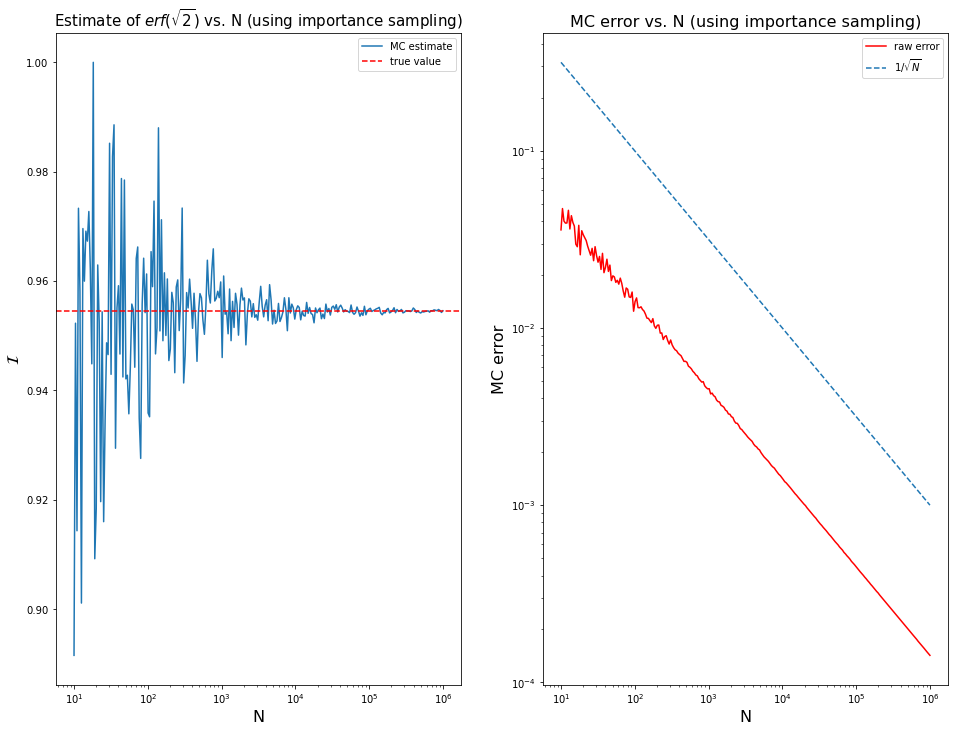

In [10]:
plt.figure(figsize = (16,12))

ax_1 = plt.subplot(121)

plt.plot(Ns_imp,estimates_imp,label = 'MC estimate')
plt.axhline(special.erf(np.sqrt(2)),linestyle ='--',c = 'r',label = 'true value')


ax_1.set_title(r'Estimate of $erf(\sqrt{2})$ vs. N (using importance sampling)',fontsize = 15)
ax_1.set_xlabel('N',fontsize = 16)
ax_1.set_ylabel(r'$\mathcal{I}$',fontsize = 16)

ax_1.set_xscale('log',basex=10)
ax_1.legend()

ax_2 = plt.subplot(122)

decay_rate = [np.sqrt(1 / N) for N in Ns_imp]

plt.plot(Ns_imp,errors_imp,c = 'r',label='raw error')
plt.plot(Ns_imp,decay_rate,linestyle = '--',label =r'1/$\sqrt{N}$')
ax_2.set_xscale('log',basex = 10)
ax_2.set_yscale('log',basey = 10)

ax_2.set_xlabel('N',fontsize = 16)
ax_2.set_ylabel('MC error',fontsize = 16)
ax_2.set_title('MC error vs. N (using importance sampling)',fontsize = 16)

#ax_2.set_ylim(1e-4,0.1)
ax_2.legend()
plt.show()

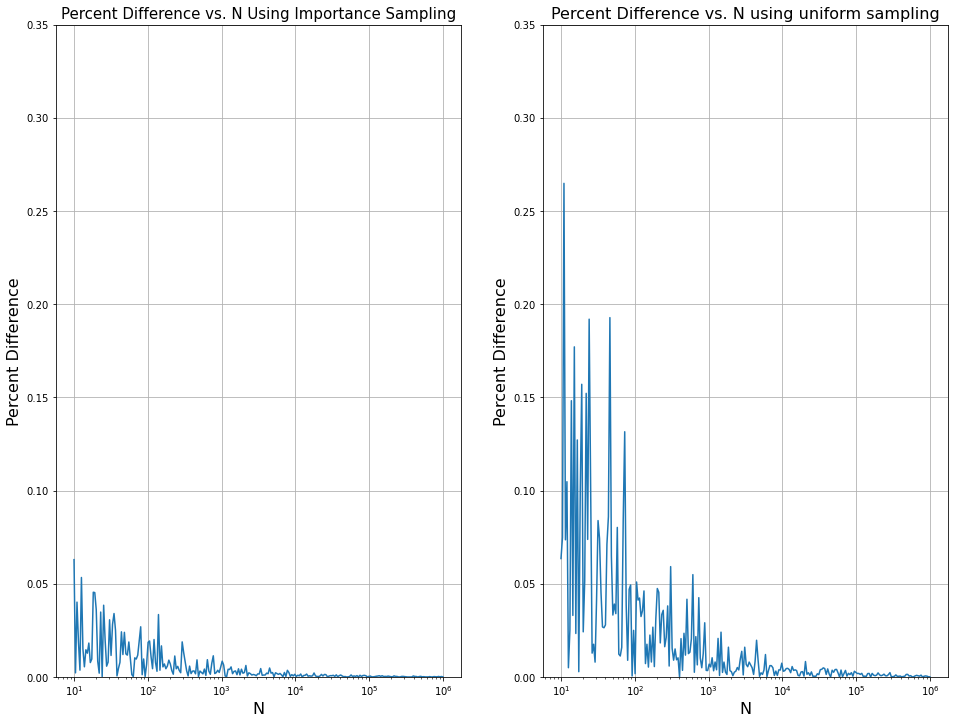

In [11]:
pct_diff_imp = abs(special.erf(np.sqrt(2)) - estimates_imp) / special.erf(2*np.sqrt(2))
#print(pct_diff)

plt.figure(figsize = (16,12))
ax = plt.subplot(121)

ax.plot(Ns_imp,pct_diff_imp)
ax.set_xscale('log',basex=10)
#ax.set_yscale('log',basey=10)

ax.set_title('Percent Difference vs. N Using Importance Sampling',fontsize = 15)
ax.set_xlabel('N',fontsize = 16)
ax.set_ylabel('Percent Difference',fontsize = 16)

ax.set_ylim(0,0.35)
plt.grid(True)    

ax = plt.subplot(122)
ax.plot(Ns,pct_diff)
ax.set_xscale('log',basex=10)
#ax.set_yscale('log',basey=10)

ax.set_title('Percent Difference vs. N using uniform sampling',fontsize = 16)
ax.set_xlabel('N',fontsize = 16)
ax.set_ylabel('Percent Difference',fontsize = 16)
ax.set_ylim(0,0.35)

plt.grid(True)    
plt.show()      

As can be seen from the two plots above, using importance sampling yields smaller (percent) errors from the onset and that dip below 0.05 at fewer than $N<10^2$ random samples. When using MC without importance sampling, however, the percent error only dips below 0.05 when $N>10^2$.

#### Part D (2 points)

Next, write a program to compute erf($\sqrt{2}$) using both the trapezoidal rule:

$$\int_{x_0}^{x_{N-1}} dx f(x) = \frac{h}{2} [ f(x_0) + 2 f(x_1) + 2 f(x_2) + ... + 2 f(x_{N-2}) + f(x_{N-1})] + \mathcal{O}(h^3 f'')$$

which uses a piecewise linear approximation for the function, and Simpson's rule:

$$\int_{x_0}^{x_{N-1}} dx f(x) = \frac{h}{3} [ f(x_0) + 4 f(x_1) + 2 f(x_2) + 4f(x_3)+... + 2f(x_{N-3})+ 4 f(x_{N-2}) + f(x_{N-1})] + \mathcal{O}(h^5 f'''')$$

which uses a piecewise-parabolic approximation for the function. In both formulas, N is the number of points sampled and h ≡ (b − a)/(N − 1) is the uniform step size taken between the integration limits a and b. (Note that N − 1 is the number of divisions.) For Simpson’s rule to work in the above form, N must be odd and ≥ 5

For each approximation, plot the error as a function of N = 5...99 and compare to the expected convergence rates. What step size h gives you roughly the same accuracy as the Monte-Carlo integration from part (b) after $10^6$ uniformly distributed random
samples?

In [12]:
def trap_rule(a,b,num_samples):
    h = (b-a)/(num_samples-1)
    
    #xs = [a + n*h for n in range(0,num_samples)]
    integral = f(a) + f(b)
    
    for n in range(1,num_samples-1):
        x = a + n*h
        integral += 2*f(x)
        
    integral *=h/2
    return integral

def simpsons_rule(a,b,num_samples):
    if (num_samples%2 == 0) or (num_samples < 5):
        print('This function only works for odd N >= 5')
        return
    else:
        h = (b-a)/(num_samples-1)
        
        integral = f(a) + f(b)
        
        for n in range(1,num_samples-1):
            x  = a +n*h
            if n%2 !=0:
                integral += 4*f(x)
            else:
                integral += 2*f(x)
                
        integral *=h/3
        
        return integral

In [13]:
trap=trap_rule(0,np.sqrt(2),1000)
simp = simpsons_rule(0,np.sqrt(2),1001)


Ns_trap = np.linspace(5,99,95)
Ns_simp = np.linspace(5,99,48)

traps = np.zeros(Ns_trap.size)
simps = np.zeros(Ns_simp.size)

for i in range(len(Ns_trap)):
    N = int(Ns_trap[i])
    traps[i] = (trap_rule(0,np.sqrt(2),N))

for i in range(len(Ns_simp)):
    N = int(Ns_simp[i])
    simps[i]=(simpsons_rule(0,np.sqrt(2),N))    


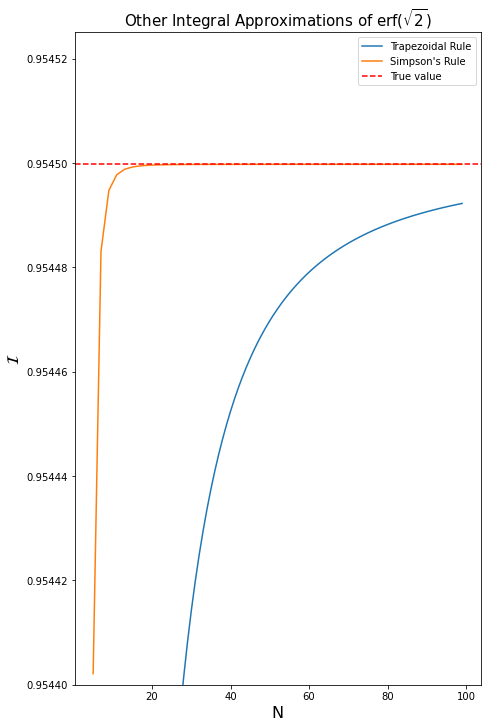

In [14]:
plt.figure(figsize = (16,12))

ax_1 = plt.subplot(121)

ax_1.plot(Ns_trap,traps,label ='Trapezoidal Rule')
ax_1.plot(Ns_simp,simps,label = 'Simpson\'s Rule')

ax_1.set_title(r'Other Integral Approximations of erf($\sqrt{2}$)',fontsize = 15)
ax_1.set_xlabel('N',fontsize = 16)
ax_1.set_ylabel(r'$\mathcal{I}$',fontsize = 16)

ax_1.axhline(special.erf(np.sqrt(2)),linestyle = '--',color = 'r',label = 'True value')

ax_1.set_ylim(0.9544,0.954525)

plt.legend()
plt.show()

In [15]:
print(r'After 10^6 uniformly distributed samples, Monte Carlo integration gives a fractional error of {:.2e}'.format(pct_diff[-1]))

pct_diff_simp =abs(special.erf(np.sqrt(2)) - simps) / special.erf(np.sqrt(2))
pct_diff_trap =abs(special.erf(np.sqrt(2)) - traps) / special.erf(np.sqrt(2))


print('\n Simpson\'s fractional errors: \n --------------------------------------------------------------------------------------- \n'\
      ,pct_diff_simp)
print()
print('Trapezoidal fractional errors:\n ----------------------------------------------------------------------------------- \n',\
      pct_diff_trap)

After 10^6 uniformly distributed samples, Monte Carlo integration gives a fractional error of 7.53e-05

 Simpson's fractional errors: 
 --------------------------------------------------------------------------------------- 
 [1.02260422e-04 1.74707308e-05 5.24936688e-06 2.09912621e-06
 9.99172589e-07 5.35093988e-07 3.12060957e-07 1.94135483e-07
 1.27052825e-07 8.66176750e-08 6.10714705e-08 4.42906601e-08
 3.28998771e-08 2.49479860e-08 1.92606187e-08 1.51059128e-08
 1.20137545e-08 9.67402492e-09 7.87727449e-09 6.47903981e-09
 5.37778422e-09 4.50091704e-09 3.79573237e-09 3.22342265e-09
 2.75503833e-09 2.36873202e-09 2.04783049e-09 1.77948364e-09
 1.55369131e-09 1.36260553e-09 1.20001650e-09 1.06097257e-09
 9.41498464e-10 8.38379013e-10 7.48999812e-10 6.71221136e-10
 6.03281982e-10 5.43726206e-10 4.91341694e-10 4.45117089e-10
 4.04203178e-10 3.67883464e-10 3.35553807e-10 3.06699166e-10
 2.80880106e-10 2.57722208e-10 2.36902234e-10 2.18143706e-10]

Trapezoidal fractional errors:
 --------

**We conclude from our findings:**
* Simpson's rule has a fractional error below MC integration with N = 10<sup>6</sup> with N<sub>simp</sub> = 5, **$h=\frac{(b-a)}{N-1}=\frac{\sqrt{2}}{4}$**, (error = 1.023 x 10<sup>-4</sup>)

* The Trapezoidal rule has a fractional error below MC integration with N = 10<sup>6</sup> with N<sub>trap</sub> = 14, $h=\frac{(b-a)}{N-1}=\frac{\sqrt{2}}{13}$,  (error = 4.46 x 10<sup>-4</sup>)

#### Part E (0.25 points)

Now the easy way out. In python, type the following:

```
import numpy as np
import scipy.integrate as integ

def f(x):
    return 2/np.sqrt(np.pi)*np.exp(-x*x)
    
integ.quad(f,0,np.sqrt(2))
```
Voila. This should return the result plus an estimate of the error. Write down this answer so that we know you did this part (free points!), and then visit https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html.
(You can even do integ.quad(f,0,Inf) with this function!)

In [16]:
import numpy as np
import scipy.integrate as integ

def f(x):
    return 2/np.sqrt(np.pi)*np.exp(-x*x)

answer = integ.quad(f,0,np.sqrt(2))

print('The scipy function gives an answer of {} with an error of {}'.format(*answer))

The scipy function gives an answer of 0.9544997361036415 with an error of 1.0597075840208986e-14


### Problem 2: Simulating a planetary system.

Something that astronomers sometimes do to sanity check their fit of exoplanet data is use an N-body integrator to solve

$$\frac{d\mathbf{r}_i}{dt} = \mathbf{v}_i \text{ and } \frac{d\mathbf{v}_i}{dt} = \sum_{i\neq j}^{N} \frac{G m_j \mathbf{r}_{ij}}{r_{ij}^3} , \text{ where } \mathbf{r}_{ij} \equiv \mathbf{r}_j = \mathbf{r}_i$$

and check whether or not their fit parameters result in a dynamically stable system. In this problem, I’ll teach you how to write your own two-body integrator, which we’ll use to continue HW03’s study of the exoplanetary system HAT-P-21. Start by visiting

http://openexoplanetcatalogue.com/planet/HAT-P-21%20b/

and fetching the planet mass $m_p$, the orbital eccentricity e, the semi-major axis a, and the host star’s mass $m_s$. Recalling footnote 3 from HW03, you’d be best served by measuring time in yr, length in au, and mass in $M_\odot$ = 1047.592421 $M_J$, where $M_J$ is the mass of Jupiter.
If you do so, then Kepler’s third law gives a rather simple gravitational constant G = $(2\pi)^2$ .

*The parameters are:*
* m<sub>p</sub> = 4.06 M<sub>J</sub>
* e = 0.228
* a = 0.0494 Au
* m<sub>s</sub> = 0.947 $M_\odot$

In [17]:
import astropy.constants as const
import astropy.units as u_

mp_HP21b = ((4.06*const.M_jup).to(u_.solMass).value)
e_HP21b = 0.228
a_HP21b = 0.0494 #AU
ms_HP21b = (0.947*u_.solMass).value


#### Part A (1.25 Points)

Pretty much the worst thing you can do is use forward-Euler to solve the two-body problem. You can find some python code that I wrote at

https://www.astro.princeton.edu/~kunz/Site/AST303/euler-Nbody.py

that does forward-Euler for an arbitrary number of bodies.
insert the values for $m_p$, e, a, and $m_s$ where indicated. Then run the code and make plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. (The latter should be a ```semilogy``` plot. Don’t forget to label your axes and specify their units.) Describe these plots in words.

In [18]:
import numpy as np

# computes gravitational acceleration of mass i due to all masses j != i
def compute_gravity(i,x,y,z):
    ax = 0 ; ay = 0 ; az = 0
    jlist = [k for k in range(nbody) if k != i]
    for j in jlist:                                   # loop over all masses j != i
        xsep = x[j]-x[i]                                # x_{ij} = x_j - x_i
        ysep = y[j]-y[i]                                # y_{ij} = y_j - y_i
        zsep = z[j]-z[i]                                # z_{ij} = z_j - z_i
        grav = m[j]*(xsep**2+ysep**2+zsep**2)**(-1.5)   # gravity on mass i due to mass j
        ax += grav*xsep                                 # x-component of gravity
        ay += grav*ysep                                 # y-component of gravity
        az += grav*zsep                                 # z-component of gravity
    return (ax,ay,az)                                 # return gravitational acceleration

# computes total (kinetic + potential) energy of all masses
def compute_energy(x,y,z,u,v,w):
    ke = 0. ; pe = 0.
    for i in range(nbody):
        ke += 0.5*m[i]*(u[i]**2+v[i]**2+w[i]**2)        # compute kinetic energy of mass i
        jlist = [k for k in range(nbody) if k > i]      # do sum over masses k > i
        for j in jlist:
            xsep = x[j]-x[i]                              # compute potential energy of mass i
            ysep = y[j]-y[i]
            zsep = z[j]-z[i]
            pe  -= m[i]*m[j]*(xsep**2+ysep**2+zsep**2)**(-0.5)
    return (ke+pe)/gconst                # return total energy (in proper units)

# computes total angular momentum of all masses
def compute_angmom(x,y,z,u,v,w):
    L = 0.
    for i in range(nbody):
        # compute angular momentum of mass i
        L += m[i]*np.sqrt( (y[i]*w[i]-z[i]*v[i])**2 \
                          +(z[i]*u[i]-x[i]*w[i])**2 \
                          +(x[i]*v[i]-y[i]*u[i])**2)
    return L/gconst         # return total ang. mom. (in proper units)

##############################################################################################
##############################################################################################

nbody = 2                # number of bodies
dt = 0.00001              # time step [yr]
tfinal = 2**17*dt        # final time [yr]

# gravitational constant in units where yr = au = Msun = 1
gconst = (2*np.pi)**2

# pre-declare arrays for speed
tsize = int(tfinal/dt)
t = np.zeros(tsize)         ; enrg = np.zeros(tsize)      ; angm = np.zeros(tsize)
x = np.zeros((tsize,nbody)) ; y = np.zeros((tsize,nbody)) ; z = np.zeros((tsize,nbody))
u = np.zeros((tsize,nbody)) ; v = np.zeros((tsize,nbody)) ; w = np.zeros((tsize,nbody))

# two-body planetary system
ms = ms_HP21b
mp = mp_HP21b
m = gconst*np.array([ms,mp])
e = e_HP21b
a = a_HP21b
r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt((m[0]+m[1])*(2/r0-1/a))

# initial positions and velocities for each mass
i = 0
x[0,i] =  0.                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  0.                ; w[0,i] =  0.
i += 1
x[0,i] =  r0                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  v0                ; w[0,i] =  0.

# compute initial total energy of system
enrg[0] = compute_energy(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# compute initial angular momentum of system
angm[0] = compute_angmom(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# begin Euler integration
for n in range(tsize-1):                    # loop over times
    for i in range(nbody):                  # loop over masses i=0,1,...,(nbody-1)

        # compute gravitational acceleration for mass i using current positions
        (ax,ay,az) = compute_gravity(i,x[n,:],y[n,:],z[n,:])

        # update position and velocity of mass i
        x[n+1,i] = x[n,i] + dt*u[n,i]
        y[n+1,i] = y[n,i] + dt*v[n,i]
        z[n+1,i] = z[n,i] + dt*w[n,i]
        u[n+1,i] = u[n,i] + dt*ax
        v[n+1,i] = v[n,i] + dt*ay
        w[n+1,i] = w[n,i] + dt*az

  # increment time and store
    t[n+1] = t[n] + dt

  # compute total energy of system
    enrg[n+1] = compute_energy(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])

  # compute angular momentum of system
    angm[n+1] = compute_angmom(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])


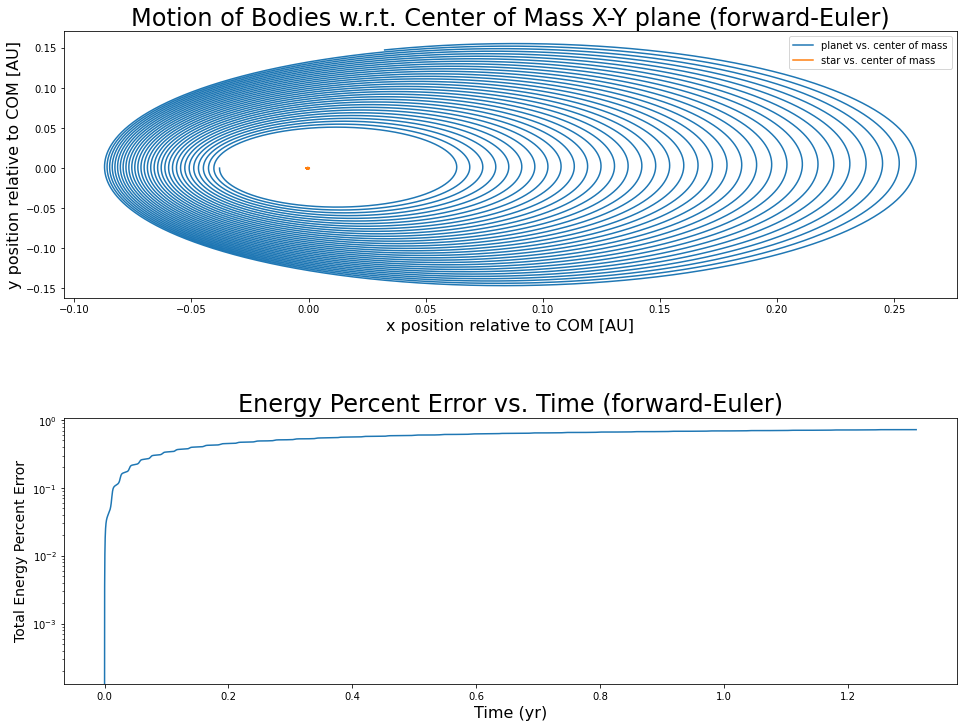

In [19]:
fig = plt.figure(figsize = (16,12))

x_cms = np.zeros(len(x))
y_cms = np.zeros(len(y))
x_1 = np.zeros(len(x))
x_0 = np.zeros(len(x))
y_1 = np.zeros(len(y))
y_0 = np.zeros(len(y))

for i in range(len(x)):
    x_cms[i] = (1 /(ms+mp))*(ms*x[i,1] + mp*x[i,0])
    y_cms[i] = (1 /(ms+mp))*(ms*y[i,1] + mp*y[i,0])
    x_1[i] = x[i,1]
    x_0[i] = x[i,0]
    y_1[i] = y[i,1]
    y_0[i] = y[i,0]

ax= plt.subplot(211)

#ax.plot(x[:,0],y[:,0],label = 'star')
#ax.plot(x[:,1],y[:,1],label = 'planet')
ax.plot(x_0-x_cms,y_0-y_cms,label = 'planet vs. center of mass')
ax.plot(x_1-x_cms,y_1-y_cms,label = 'star vs. center of mass')

ax.set_xlabel('x position relative to COM [AU]',fontsize = 16)
ax.set_ylabel('y position relative to COM [AU]',fontsize = 16)
ax.set_title('Motion of Bodies w.r.t. Center of Mass X-Y plane (forward-Euler)',fontsize = 24)
#ax.legend()
plt.legend()
ax = plt.subplot(212)

#taking the absolute value of energy since all of the values are negative (as it should \
#be for a bound orbit)
ax.semilogy(t,abs(enrg-enrg[0])/abs(enrg[0]))
ax.set_xlabel('Time (yr)',fontsize = 16)
ax.set_ylabel('Total Energy Percent Error',fontsize = 14)
ax.set_title('Energy Percent Error vs. Time (forward-Euler)', fontsize = 24)

fig.subplots_adjust(hspace = 0.45)


plt.show()

From the above plots, we can better understand the behavior of this two-body system; In the plot of COM position, we see an elliptic oscillation of planet about the center of mass. The position of the star (practically at the center of mass of the system) stays fixed over time. This makes sense in line with the error of the energy that we found, whereby the energy becomes less negative (absolute value decreases) over time, and we know that $E\propto{1/r}$. In the plot of energy vs. time, we can see that the error in the measurement of energy increases over time. The two-body system should be conserving energy, so any energy measurements that deviate from the energy value at t=0 will have an error associated with them, and this error only increases (to a maximum of 100%) as we go forward in time.

#### Part B (1.25 Points)

Perhaps the next best thing to use is second-order Runge-Kutta (RK2). You can find some python code that I wrote at

https://www.astro.princeton.edu/~kunz/Site/AST303/rk2-Nbody.py

that does RK2 for an arbitrary number of bodies. Insert the values for $m_p$, e, a, and $m_s$ where indicated. Then run the code and make plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. (The latter should be a ```semilogy``` plot. Don’t forget to label your axes and specify their units.) Describe these plots in words.

In [20]:
nbody = 2                # number of bodies
dt = 0.00001              # time step [yr]
tfinal = 2**17*dt        # final time [yr]

# gravitational constant in units where yr = au = Msun = 1
gconst = (2*np.pi)**2

# pre-declare arrays for speed
tsize = int(tfinal/dt)
t = np.zeros(tsize)         ; enrg = np.zeros(tsize)      ; angm = np.zeros(tsize)
x = np.zeros((tsize,nbody)) ; y = np.zeros((tsize,nbody)) ; z = np.zeros((tsize,nbody))
u = np.zeros((tsize,nbody)) ; v = np.zeros((tsize,nbody)) ; w = np.zeros((tsize,nbody))

# two-body planetary system
ms = ms_HP21b
mp = mp_HP21b
m = gconst*np.array([ms,mp])
e = e_HP21b
a = a_HP21b
r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt((m[0]+m[1])*(2/r0-1/a))

# initial positions and velocities for each mass
i = 0
x[0,i] =  0.                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  0.                ; w[0,i] =  0.
i += 1
x[0,i] =  r0                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  v0                ; w[0,i] =  0.

# compute initial total energy of system
enrg[0] = compute_energy(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# compute initial angular momentum of system
angm[0] = compute_angmom(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# declare temporary storage arrays for RK integration
k1 = np.zeros((nbody,6)) ; k2 = np.zeros((nbody,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

# begin RK2 integration
for n in range(tsize-1):                         # loop over times
  
  # stage 1
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
    # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:],y[n,:],z[n,:])
        # store k1
        k1[i,ix] = dt*u[n,i]
        k1[i,iy] = dt*v[n,i]
        k1[i,iz] = dt*w[n,i]
        k1[i,iu] = dt*ax
        k1[i,iv] = dt*ay
        k1[i,iw] = dt*az
  
  # stage 2
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:]+0.5*k1[:,ix],y[n,:]+0.5*k1[:,iy],z[n,:]+0.5*k1[:,iz])
        # store k2
        k2[i,ix] = dt*(u[n,i]+0.5*k1[i,iu])
        k2[i,iy] = dt*(v[n,i]+0.5*k1[i,iv])
        k2[i,iz] = dt*(w[n,i]+0.5*k1[i,iw])
        k2[i,iu] = dt*ax
        k2[i,iv] = dt*ay
        k2[i,iw] = dt*az
  
  # update position and velocity of mass i
    for i in range(nbody):
        x[n+1,i] = x[n,i] + k2[i,ix]
        y[n+1,i] = y[n,i] + k2[i,iy]
        z[n+1,i] = z[n,i] + k2[i,iz]
        u[n+1,i] = u[n,i] + k2[i,iu]
        v[n+1,i] = v[n,i] + k2[i,iv]
        w[n+1,i] = w[n,i] + k2[i,iw]

  # increment time
    t[n+1] = t[n] + dt

  # compute total energy of system
    enrg[n+1] = compute_energy(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])

  # compute angular momentum of system
    angm[n+1] = compute_angmom(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])

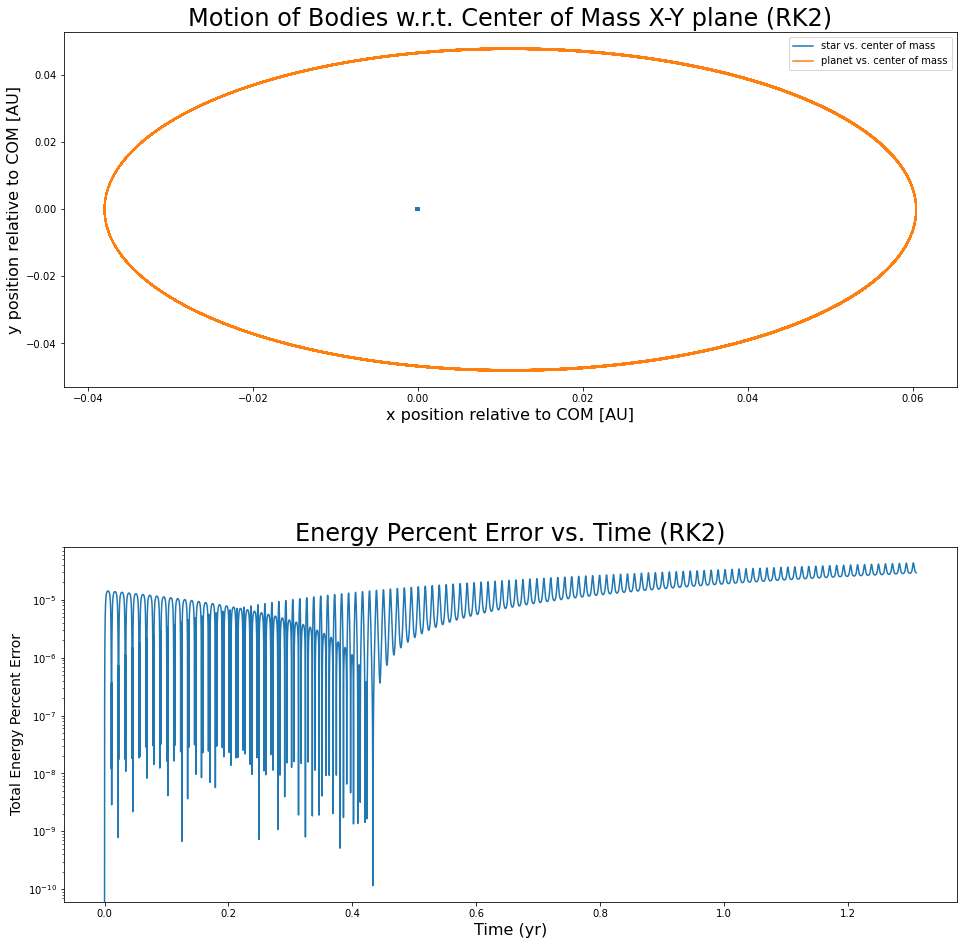

In [21]:
fig = plt.figure(figsize = (16,16))

x_cms = np.zeros(len(x))
y_cms = np.zeros(len(y))
x_1 = np.zeros(len(x))
x_0 = np.zeros(len(x))
y_1 = np.zeros(len(y))
y_0 = np.zeros(len(y))

for i in range(len(x)):
    x_cms[i] = (1 /(ms+mp))*(ms*x[i,1] + mp*x[i,0])
    y_cms[i] = (1 /(ms+mp))*(ms*y[i,1] + mp*y[i,0])
    x_1[i] = x[i,1]
    x_0[i] = x[i,0]
    y_1[i] = y[i,1]
    y_0[i] = y[i,0]


errors_RK2 = abs(enrg-enrg[0])

ax= plt.subplot(211)

#ax.plot(x[:,0],y[:,0],label = 'star')
#ax.plot(x[:,1],y[:,1],label = 'planet')
ax.plot(x_1-x_cms,y_1-y_cms,label = 'star vs. center of mass')
ax.plot(x_0-x_cms,y_0-y_cms,label = 'planet vs. center of mass')

ax.set_xlabel('x position relative to COM [AU]',fontsize = 16)
ax.set_ylabel('y position relative to COM [AU]',fontsize = 16)
ax.set_title('Motion of Bodies w.r.t. Center of Mass X-Y plane (RK2)',fontsize = 24)
#ax.legend()
plt.legend()
ax = plt.subplot(212)

#taking the absolute value of energy since all of the values are negative (as it should \
#be for a bound orbit)
ax.semilogy(t,np.abs(enrg-enrg[0])/np.abs(enrg[0]))
            # abs(enrg-enrg[0])/abs(enrg[0]))
ax.set_xlabel('Time (yr)',fontsize = 16)
ax.set_ylabel('Total Energy Percent Error',fontsize = 14)
ax.set_title('Energy Percent Error vs. Time (RK2)', fontsize = 24)

fig.subplots_adjust(hspace = 0.45)

plt.show()


In the plot of COM position, we see that the star stays at its location (roughly at the center of mass) throughout, and the planet's orbit doesn't seem to change much over time either. Here, the error also reaches $10^{-5}$, which is much smaller than in the previous example. A smaller error in energy measurement would also lead to less skew in the position measurement, which is why the orbit of the planet about the center of mass appears to be fixed more than it is in part a.

#### Part C (4 Points)

This is a problem set. So then why am I writing your code for you?! Well, because you are now going to use that code as a template to write your own. Upgrade the RK2 code to a fourth-order Runge-Kutta (RK4) code. Use it to integrate the same two-body problem as in parts (a) and (b)—same timestep h, same total integration time tf, same masses and initial conditions—and make labelled plots of (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. This should look much better than the RK2 solution. . . in fact, it should look ∼O(h2) better. Show this explicitly by comparing |$\mathcal{E}(t_f)$ − $\mathcal{E}$(0)| for RK2 and RK4.

In [22]:
nbody = 2                # number of bodies
dt = 0.00001              # time step [yr]
tfinal = 2**17*dt        # final time [yr]

# gravitational constant in units where yr = au = Msun = 1
gconst = (2*np.pi)**2

# pre-declare arrays for speed
tsize = int(tfinal/dt)
t = np.zeros(tsize)         ; enrg = np.zeros(tsize)      ; angm = np.zeros(tsize)
x = np.zeros((tsize,nbody)) ; y = np.zeros((tsize,nbody)) ; z = np.zeros((tsize,nbody))
u = np.zeros((tsize,nbody)) ; v = np.zeros((tsize,nbody)) ; w = np.zeros((tsize,nbody))

# two-body planetary system
ms = ms_HP21b
mp = mp_HP21b
m = gconst*np.array([ms,mp])
e = e_HP21b
a = a_HP21b
r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt((m[0]+m[1])*(2/r0-1/a))

# initial positions and velocities for each mass
i = 0
x[0,i] =  0.                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  0.                ; w[0,i] =  0.
i += 1
x[0,i] =  r0                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  v0                ; w[0,i] =  0.

# compute initial total energy of system
enrg[0] = compute_energy(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# compute initial angular momentum of system
angm[0] = compute_angmom(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# declare temporary storage arrays for RK integration
k1 = np.zeros((nbody,6)) ; k2 = np.zeros((nbody,6)) ; k3 = np.zeros((nbody,6)) ; k4 = np.zeros((nbody,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

# begin RK2 integration
for n in range(tsize-1):                         # loop over times
  
  # stage 1
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
    # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:],y[n,:],z[n,:])
        # store k1
        k1[i,ix] = dt*u[n,i]
        k1[i,iy] = dt*v[n,i]
        k1[i,iz] = dt*w[n,i]
        k1[i,iu] = dt*ax
        k1[i,iv] = dt*ay
        k1[i,iw] = dt*az
  
  # stage 2
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:]+0.5*k1[:,ix],y[n,:]+0.5*k1[:,iy],z[n,:]+0.5*k1[:,iz])
        # store k2
        k2[i,ix] = dt*(u[n,i]+0.5*k1[i,iu])
        k2[i,iy] = dt*(v[n,i]+0.5*k1[i,iv])
        k2[i,iz] = dt*(w[n,i]+0.5*k1[i,iw])
        k2[i,iu] = dt*ax
        k2[i,iv] = dt*ay
        k2[i,iw] = dt*az
        
  # stage 3
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:]+0.5*k2[:,ix],y[n,:]+0.5*k2[:,iy],z[n,:]+0.5*k2[:,iz])
        # store k3
        k3[i,ix] = dt*(u[n,i]+0.5*k2[i,iu])
        k3[i,iy] = dt*(v[n,i]+0.5*k2[i,iv])
        k3[i,iz] = dt*(w[n,i]+0.5*k2[i,iw])
        k3[i,iu] = dt*ax
        k3[i,iv] = dt*ay
        k3[i,iw] = dt*az

  # stage 4
    for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
        (ax,ay,az) = compute_gravity(i,x[n,:]+k3[:,ix],y[n,:]+k3[:,iy],z[n,:]+k3[:,iz])
        # store k4
        k4[i,ix] = dt*(u[n,i]+k3[i,iu])
        k4[i,iy] = dt*(v[n,i]+k3[i,iv])
        k4[i,iz] = dt*(w[n,i]+k3[i,iw])
        k4[i,iu] = dt*ax
        k4[i,iv] = dt*ay
        k4[i,iw] = dt*az
        
  
  # update position and velocity of mass i
    for i in range(nbody):
        x[n+1,i] = x[n,i] + (1/6)*(k1[i,ix]+2*k2[i,ix]+2*k3[i,ix]+k4[i,ix])
        y[n+1,i] = y[n,i] + (1/6)*(k1[i,iy]+2*k2[i,iy]+2*k3[i,iy]+k4[i,iy])
        z[n+1,i] = z[n,i] + (1/6)*(k1[i,iz]+2*k2[i,iz]+2*k3[i,iz]+k4[i,iz])
        u[n+1,i] = u[n,i] + (1/6)*(k1[i,iu]+2*k2[i,iu]+2*k3[i,iu]+k4[i,iu])
        v[n+1,i] = v[n,i] + (1/6)*(k1[i,iv]+2*k2[i,iv]+2*k3[i,iv]+k4[i,iv])
        w[n+1,i] = w[n,i] + (1/6)*(k1[i,iw]+2*k2[i,iw]+2*k3[i,iw]+k4[i,iw])

  # increment time
    t[n+1] = t[n] + dt

  # compute total energy of system
    enrg[n+1] = compute_energy(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])

  # compute angular momentum of system
    angm[n+1] = compute_angmom(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])

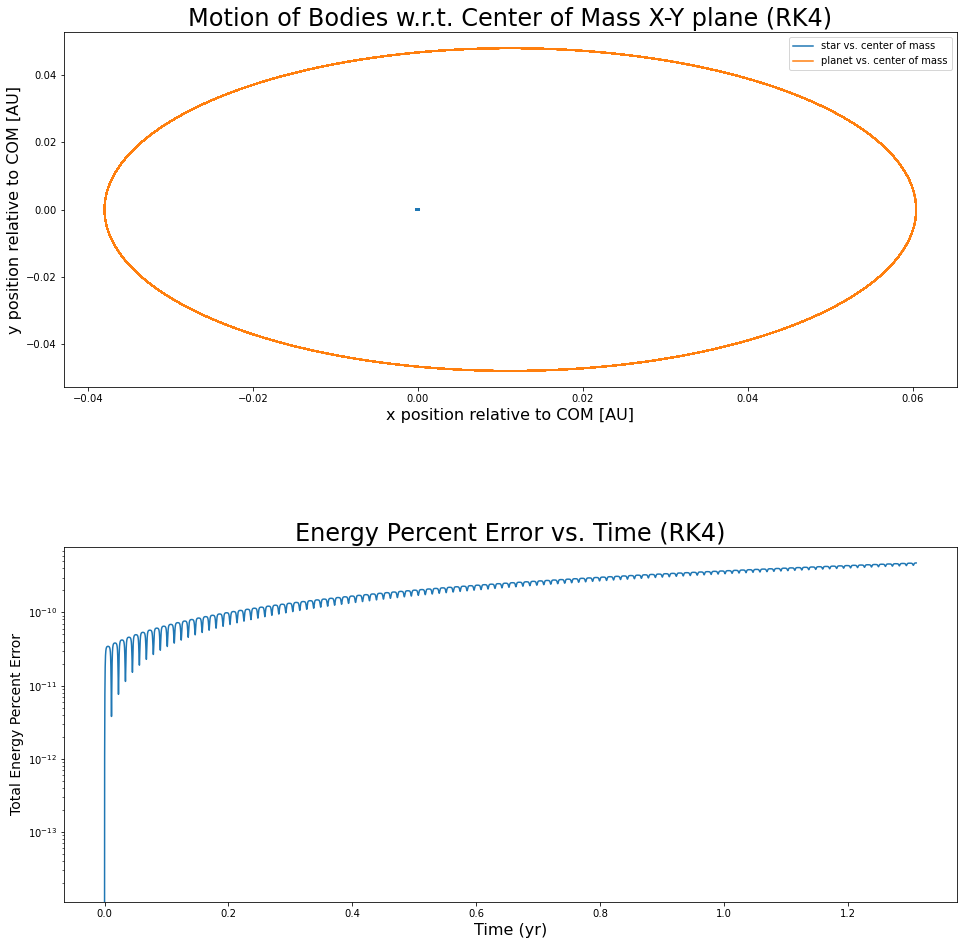

In [23]:
fig = plt.figure(figsize = (16,16))

x_cms = np.zeros(len(x))
y_cms = np.zeros(len(y))
x_1 = np.zeros(len(x))
x_0 = np.zeros(len(x))
y_1 = np.zeros(len(y))
y_0 = np.zeros(len(y))

for i in range(len(x)):
    x_cms[i] = (1 /(ms+mp))*(ms*x[i,1] + mp*x[i,0])
    y_cms[i] = (1 /(ms+mp))*(ms*y[i,1] + mp*y[i,0])
    x_1[i] = x[i,1]
    x_0[i] = x[i,0]
    y_1[i] = y[i,1]
    y_0[i] = y[i,0]

errors_RK4 = abs(enrg-enrg[0])
ax= plt.subplot(211)

#ax.plot(x[:,0],y[:,0],label = 'star')
#ax.plot(x[:,1],y[:,1],label = 'planet')
ax.plot(x_1-x_cms,y_1-y_cms,label = 'star vs. center of mass')
ax.plot(x_0-x_cms,y_0-y_cms,label = 'planet vs. center of mass')

ax.set_xlabel('x position relative to COM [AU]',fontsize = 16)
ax.set_ylabel('y position relative to COM [AU]',fontsize = 16)
ax.set_title('Motion of Bodies w.r.t. Center of Mass X-Y plane (RK4)',fontsize = 24)
#ax.legend()
plt.legend()
ax = plt.subplot(212)

#taking the absolute value of energy since all of the values are negative (as it should \
#be for a bound orbit)
ax.semilogy(t,abs(enrg-enrg[0])/abs(enrg[0]))
ax.set_xlabel('Time (yr)',fontsize = 16)
ax.set_ylabel('Total Energy Percent Error',fontsize = 14)
ax.set_title('Energy Percent Error vs. Time (RK4)', fontsize = 24)

fig.subplots_adjust(hspace = 0.45)

plt.show()

In [24]:
diff_final_error = (errors_RK2-errors_RK4)[len(errors_RK2)-1]
print(diff_final_error)

4.258238292309535e-05


As you can see, the orbit in RK4 is much more tight, and it is very hard to see any deviation from an ellipse for the planet in the center of mass frame. Also, the energy error converges on the order of 10<sup>-10</sup>, which is 5 orders of magnitude lower than RK2.

#### Part D (4 Points)

Write a python routine to integrate the two-body system using the leapfrog method. As explained in class, you need to first obtain one of the variables at the half-step to begin the leapfrog integration. It’s your choice which one to offset. If you choose to offset **x**<sub>n</sub> to **x**<sub>n+ 1/2</sub>, then the velocity is updated via $\mathbf{v}_{n+1} = \mathbf{v}_n + \Delta t \; \mathbf{a}(\mathbf{x}_{n+ 1/2})$. If you instead choose to offset**v**<sub>n</sub> to **v**<sub>n+ 1/2</sub> then the position is updated via $\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \; \mathbf{v}_{n+1/2}$. Whichever version you choose, use my RK2 code to obtain the initial value of the offset variable by integrating (7) for a time h/2. Once you have this, leapfrog takes over...

Once finished, plot (i) the orbit in the x-y plane of the center-of-mass frame and (ii) the error in the total energy versus time. If you’ve done it correctly, the error in the energy of the system will not grow in time! But recall the discussion in class: To compute $\mathcal{E}(t)$, the velocities and positions are required at the same time, which is not a natural state of affairs during a leapfrog integration. One way to do this is to update the positions over a time interval h/2 first to make it cotemporal with the velocity, then compute $\mathcal{E}$, a leapfrog where one of the people leapfrogging (**r**) pauses mid-air over the back of the other (**v**), performs a calculation ($\mathcal{E}$), and then keeps going. You can achieve this via the drift-kick-drift or kick-drift-kick formulations of the leapfrog method.

In [31]:
nbody = 2                # number of bodies
dt = 0.00001              # time step [yr]
tfinal = 2**17*dt        # final time [yr]

# gravitational constant in units where yr = au = Msun = 1
gconst = (2*np.pi)**2

# pre-declare arrays for speed
tsize = int(tfinal/dt)
t = np.zeros(tsize)         ; enrg = np.zeros(tsize)      ; angm = np.zeros(tsize)
x = np.zeros((tsize,nbody)) ; y = np.zeros((tsize,nbody)) ; z = np.zeros((tsize,nbody))
u = np.zeros((tsize,nbody)) ; v = np.zeros((tsize,nbody)) ; w = np.zeros((tsize,nbody))

# two-body planetary system
ms = ms_HP21b
mp = mp_HP21b
m = gconst*np.array([ms,mp])
e = e_HP21b
a = a_HP21b
r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt((m[0]+m[1])*(2/r0-1/a))

# initial positions and velocities for each mass
i = 0
x[0,i] =  0.                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  0.                ; w[0,i] =  0.
i += 1
x[0,i] =  r0                ; y[0,i] =  0.                ; z[0,i] =  0.
u[0,i] =  0.                ; v[0,i] =  v0                ; w[0,i] =  0.

# compute initial total energy of system
enrg[0] = compute_energy(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# compute initial angular momentum of system
angm[0] = compute_angmom(x[0,:],y[0,:],z[0,:],u[0,:],v[0,:],w[0,:])

# declare temporary storage arrays for RK integration
k1 = np.zeros((nbody,6)) ; k2 = np.zeros((nbody,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

halfdt = dt/2
# begin RK2 integration

  
  # stage 1
for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
    # compute gravitational acceleration of mass i due to all masses j != i
    (ax,ay,az) = compute_gravity(i,x[0,:],y[0,:],z[0,:])
        # store k1
    k1[i,ix] = 0.5*dt*u[0,i]
    k1[i,iy] = 0.5*dt*v[0,i]
    k1[i,iz] = 0.5*dt*w[0,i]
    k1[i,iu] = 0.5*dt*ax
    k1[i,iv] = 0.5*dt*ay
    k1[i,iw] = 0.5*dt*az
  
  # stage 2
for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
    (ax,ay,az) = compute_gravity(i,x[0,:]+0.5*k1[:,ix],y[0,:]+0.5*k1[:,iy],z[0,:]+0.5*k1[:,iz])
        # store k2
    k2[i,ix] = halfdt*(u[0,i]+0.5*k1[i,iu])
    k2[i,iy] = halfdt*(v[0,i]+0.5*k1[i,iv])
    k2[i,iz] = halfdt*(w[0,i]+0.5*k1[i,iw])
    k2[i,iu] = halfdt*ax
    k2[i,iv] = halfdt*ay
    k2[i,iw] = halfdt*az
  
 # find the position of mass i at t = 1/2
for i in range(nbody):
    x[0,i] += k2[i,ix]
    y[0,i] += k2[i,iy]
    z[0,i] += k2[i,iz]

# begin Leapfrog integration
for n in range(tsize-1):                    # loop over times
    for i in range(nbody):                  # loop over masses i=0,1,...,(nbody-1)

        (ax,ay,az) = compute_gravity(i,x[n,:],y[n,:],z[n,:])
        # update velocity to n+1 using positions at n+0.5
        u[n+1,i] = u[n,i] + dt*ax
        v[n+1,i] = v[n,i] + dt*ay
        w[n+1,i] = w[n,i] + dt*az

        #half step of position to n+1 so we can calculate the energy and angmom
        x[n+1,i] = x[n,i] + u[n+1,i]*halfdt
        y[n+1,i] = y[n,i] + v[n+1,i]*halfdt
        z[n+1,i] = z[n,i] + w[n+1,i]*halfdt
        
        # compute total energy of system
    enrg[n+1] = compute_energy(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])
        # compute angular momentum of system
    angm[n+1] = compute_angmom(x[n+1,:],y[n+1,:],z[n+1,:],u[n+1,:],v[n+1,:],w[n+1,:])
        
    #push position to n+3/2
    for i in range(nbody):
        x[n+1,i] += u[n+1,i]*halfdt
        y[n+1,i] +=v[n+1,i]*halfdt
        z[n+1,i] += w[n+1,i]*halfdt

  # increment time and store
    t[n+1] = t[n] + dt

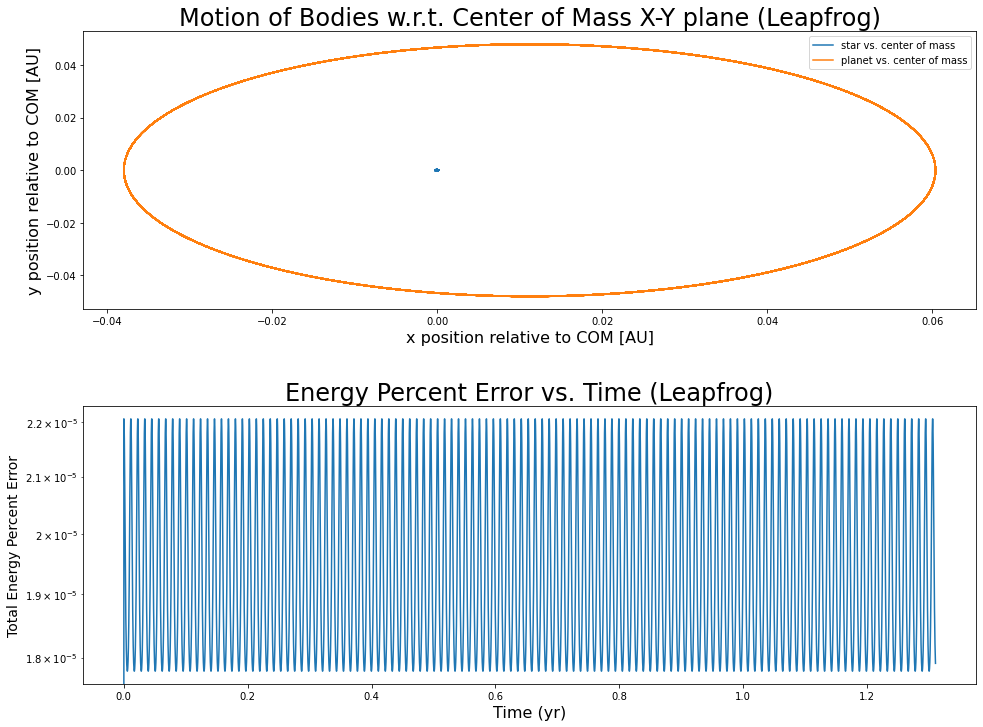

In [32]:
fig = plt.figure(figsize = (16,12))

#cm locations
x_cms = np.zeros(len(x))
y_cms = np.zeros(len(y))
x_1 = np.zeros(len(x))
x_0 = np.zeros(len(x))
y_1 = np.zeros(len(y))
y_0 = np.zeros(len(y))

for i in range(len(x)):
    x_cms[i] = (1 /(ms+mp))*(ms*x[i,1] + mp*x[i,0])
    y_cms[i] = (1 /(ms+mp))*(ms*y[i,1] + mp*y[i,0])
    x_1[i] = x[i,1]
    x_0[i] = x[i,0]
    y_1[i] = y[i,1]
    y_0[i] = y[i,0]

ax= plt.subplot(211)

#ax.plot(x[:,0],y[:,0],label = 'star')
#ax.plot(x[:,1],y[:,1],label = 'planet')
ax.plot(x_1-x_cms,y_1-y_cms,label = 'star vs. center of mass')
ax.plot(x_0-x_cms,y_0-y_cms,label = 'planet vs. center of mass')

ax.set_xlabel('x position relative to COM [AU]',fontsize = 16)
ax.set_ylabel('y position relative to COM [AU]',fontsize = 16)
ax.set_title('Motion of Bodies w.r.t. Center of Mass X-Y plane (Leapfrog)',fontsize = 24)
#ax.legend()
plt.legend()
ax = plt.subplot(212)

#taking the absolute value of energy since all of the values are negative (as it should
#be for a bound orbit)
ax.semilogy(t,abs(enrg-enrg[0])/abs(enrg[0]))
ax.set_xlabel('Time (yr)',fontsize = 16)
ax.set_ylabel('Total Energy Percent Error',fontsize = 14)
ax.set_title('Energy Percent Error vs. Time (Leapfrog)', fontsize = 24)

fig.subplots_adjust(hspace = 0.35)

plt.show()

#### Part E (0.5 Points)

Re-run your leapfrog integrator but with h = $10^{-4}$ until $t_f = 2^{15}h$ (instead of the original h = $10^{-5}$ until $t_f = 2^{17}h$) Examine the orbit and the total energy. You’ll see that, while the total energy is still conserved, the orbit is precessing. Two-body Keplerian orbits should not precess! What’s going on? (Hint: Re-run your RK4 integrator with $h = 10^{-4}$ and $t_f = 2^{15}$ and examine the orbit. What's different?)

Because the code template I gave you works for an arbitrary number of bodies (as should your code), you could play a bit with (N > 2)-body systems if you’d like. Here are the initial conditions for a fun system only 15 light-years away:

https://www.astro.princeton.edu/~kunz/Site/AST303/GJ876_initial_conditions.py

### h = 10<sup>-4</sup> until t<sub>f</sub> = 2<sup>15</sup>h

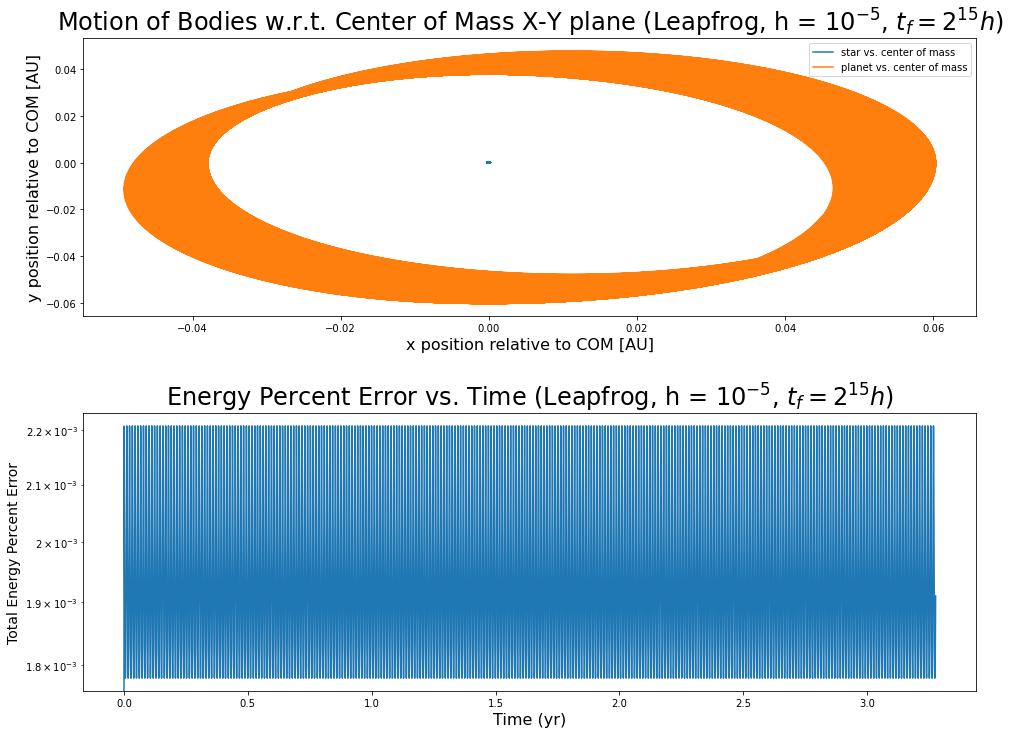

In [36]:
nbody = 2                # number of bodies
dt = 1e-4              # time step [yr]
tfinal = 2**15*dt        # final time [yr]

# gravitational constant in units where yr = au = Msun = 1
gconst = (2*np.pi)**2

# pre-declare arrays for speed
tsize = int(tfinal/dt)
t_adj = np.zeros(tsize)         ; enrg_adj = np.zeros(tsize)      ; angm_adj = np.zeros(tsize)
x_adj = np.zeros((tsize,nbody)) ; y_adj = np.zeros((tsize,nbody)) ; z_adj = np.zeros((tsize,nbody))
u_adj = np.zeros((tsize,nbody)) ; v_adj = np.zeros((tsize,nbody)) ; w_adj = np.zeros((tsize,nbody))

# two-body planetary system
ms = ms_HP21b
mp = mp_HP21b
m = gconst*np.array([ms,mp])
e = e_HP21b
a = a_HP21b
r0 = a*(1-e*e)/(1+e)
v0 = np.sqrt((m[0]+m[1])*(2/r0-1/a))

# initial positions and velocities for each mass
i = 0
x_adj[0,i] =  0.                ; y_adj[0,i] =  0.                ; z_adj[0,i] =  0.
u_adj[0,i] =  0.                ; v_adj[0,i] =  0.                ; w_adj[0,i] =  0.
i += 1
x_adj[0,i] =  r0                ; y_adj[0,i] =  0.                ; z_adj[0,i] =  0.
u_adj[0,i] =  0.                ; v_adj[0,i] =  v0                ; w_adj[0,i] =  0.

# compute initial total energy of system
enrg_adj[0] = compute_energy(x_adj[0,:],y_adj[0,:],z_adj[0,:],u_adj[0,:],v_adj[0,:],w_adj[0,:])

# compute initial angular momentum of system
angm_adj[0] = compute_angmom(x_adj[0,:],y_adj[0,:],z_adj[0,:],u_adj[0,:],v_adj[0,:],w_adj[0,:])

# declare temporary storage arrays for RK integration
k1 = np.zeros((nbody,6)) ; k2 = np.zeros((nbody,6))
ix = 0 ; iy = 1 ; iz = 2 ; iu = 3 ; iv = 4 ; iw = 5

halfdt = dt/2
# begin RK2 integration

  
  # stage 1
for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
    # compute gravitational acceleration of mass i due to all masses j != i
    (ax,ay,az) = compute_gravity(i,x_adj[0,:],y_adj[0,:],z_adj[0,:])
        # store k1
    k1[i,ix] = 0.5*dt*u_adj[0,i]
    k1[i,iy] = 0.5*dt*v_adj[0,i]
    k1[i,iz] = 0.5*dt*w_adj[0,i]
    k1[i,iu] = 0.5*dt*ax
    k1[i,iv] = 0.5*dt*ay
    k1[i,iw] = 0.5*dt*az
  
  # stage 2
for i in range(nbody):                         # loop over masses i=0,1,...,(nbody-1)
        # compute gravitational acceleration of mass i due to all masses j != i
    (ax,ay,az) = compute_gravity(i,x_adj[0,:]+0.5*k1[:,ix],y_adj[0,:]+0.5*k1[:,iy],z_adj[0,:]+0.5*k1[:,iz])
        # store k2
    k2[i,ix] = halfdt*(u_adj[0,i]+0.5*k1[i,iu])
    k2[i,iy] = halfdt*(v_adj[0,i]+0.5*k1[i,iv])
    k2[i,iz] = halfdt*(w_adj[0,i]+0.5*k1[i,iw])
    k2[i,iu] = halfdt*ax
    k2[i,iv] = halfdt*ay
    k2[i,iw] = halfdt*az
  
 # find the position of mass i at t = 1/2
for i in range(nbody):
    x_adj[0,i] += k2[i,ix]
    y_adj[0,i] += k2[i,iy]
    z_adj[0,i] += k2[i,iz]

# begin Leapfrog integration
for n in range(tsize-1):                    # loop over times
    for i in range(nbody):                  # loop over masses i=0,1,...,(nbody-1)

        (ax,ay,az) = compute_gravity(i,x_adj[n,:],y_adj[n,:],z_adj[n,:])
        # update velocity to n+1 using positions at n+0.5
        u_adj[n+1,i] = u_adj[n,i] + dt*ax
        v_adj[n+1,i] = v_adj[n,i] + dt*ay
        w_adj[n+1,i] = w_adj[n,i] + dt*az

        #half step of position to n+1 so we can calculate the energy and angmom
        x_adj[n+1,i] = x_adj[n,i] + u_adj[n+1,i]*halfdt
        y_adj[n+1,i] = y_adj[n,i] + v_adj[n+1,i]*halfdt
        z_adj[n+1,i] = z_adj[n,i] + w_adj[n+1,i]*halfdt
        
        # compute total energy of system
    enrg_adj[n+1] = compute_energy(x_adj[n+1,:],y_adj[n+1,:],z_adj[n+1,:],u_adj[n+1,:],v_adj[n+1,:],w_adj[n+1,:])
        # compute angular momentum of system
    angm_adj[n+1] = compute_angmom(x_adj[n+1,:],y_adj[n+1,:],z_adj[n+1,:],u_adj[n+1,:],v_adj[n+1,:],w_adj[n+1,:])
        
    #push position to n+3/2
    for i in range(nbody):
        x_adj[n+1,i] += u_adj[n+1,i]*halfdt
        y_adj[n+1,i] +=v_adj[n+1,i]*halfdt
        z_adj[n+1,i] += w_adj[n+1,i]*halfdt

  # increment time and store
    t_adj[n+1] = t_adj[n] + dt
    

#the code from here to the bottom just plots
fig = plt.figure(figsize = (16,12))

#cm locations
x_cms = np.zeros(len(x))
y_cms = np.zeros(len(y))
x_1 = np.zeros(len(x))
x_0 = np.zeros(len(x))
y_1 = np.zeros(len(y))
y_0 = np.zeros(len(y))

for i in range(len(x)):
    x_cms[i] = (1 /(ms+mp))*(ms*x[i,1] + mp*x[i,0])
    y_cms[i] = (1 /(ms+mp))*(ms*y[i,1] + mp*y[i,0])
    x_1[i] = x[i,1]
    x_0[i] = x[i,0]
    y_1[i] = y[i,1]
    y_0[i] = y[i,0]

ax= plt.subplot(211)

#ax.plot(x[:,0],y[:,0],label = 'star')
#ax.plot(x[:,1],y[:,1],label = 'planet')
ax.plot(x_1-x_cms,y_1-y_cms,label = 'star vs. center of mass')
ax.plot(x_0-x_cms,y_0-y_cms,label = 'planet vs. center of mass')

ax.set_xlabel('x position relative to COM [AU]',fontsize = 16)
ax.set_ylabel('y position relative to COM [AU]',fontsize = 16)
ax.set_title(r'Motion of Bodies w.r.t. Center of Mass X-Y plane (Leapfrog, h = $10^{-5}$, $t_f = 2^{15}h$)',fontsize = 24)
#ax.legend()
plt.legend()
ax = plt.subplot(212)

#taking the absolute value of energy since all of the values are negative (as it should
#be for a bound orbit)
ax.semilogy(t,abs(enrg_adj-enrg_adj[0])/abs(enrg_adj[0]))
ax.set_xlabel('Time (yr)',fontsize = 16)
ax.set_ylabel('Total Energy Percent Error',fontsize = 14)
ax.set_title('Energy Percent Error vs. Time (Leapfrog, h = $10^{-5}$, $t_f = 2^{15}h$)', fontsize = 24)

fig.subplots_adjust(hspace = 0.35)

plt.show()

*The only thing to change with the algorithm was the timestep h (the horizon, in the grand scheme of things, doesn't matter for this). What's probably happening here is that the integrator is taking too large of a timestep, and thus it updates the new positions (and velocities) too far, and are not actually following a Keplerian trajectory.* **SHAI FEEL FREE TO ADD TO THIS IF YOU THINK IT NEEDS IT**

### Problem 3: FFT'int a planetary system (3 Points)

Now that you have an orbit integrated with constant timestep, you can analyze its time series using an FFT and check that it has the same period P as declared on the exoplanet catalogue website. 

Take the time series $v_x(t)$ from Problem 2(d) and FFT it. 

Use this to plot the power spectrum of the signal versus frequency f. 

Does it peak near the period P = 1/f that you found on the website? 

Identify any numerical artifacts or higher-order peaks that you see and comment on their origin. 

Also calculate the Nyquist frequency of the data.

